In [ ]:
import sys
!cp ../input/rapids/rapids.0.18.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [1]:
# Libraries CPU
import wandb     
import cv2
import os
import gc
import random
import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import sys
sys.path = ['../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
           ] + sys.path

# Libaries GPU
import cudf
import cupy
import cuml
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors

# Pytorch & Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, Resize, Normalize, HorizontalFlip, VerticalFlip,\
                            Rotate, CenterCrop


from efficientnet_pytorch import EfficientNet
from transformers import AutoTokenizer
from torchvision.models import resnet34, resnet50

# Environment check
os.environ["WANDB_SILENT"] = "true"      


# Color scheme
my_colors = ["#EDAC54", "#F4C5B7", "#DD7555", "#B95F18", "#475A20"]

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

# Base paths
train_base = "../input/shopee-product-matching/train_images/"
test_base = "../input/shopee-product-matching/test_images/"

Device available now: cuda


In [2]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [3]:
#  Set COMPUTE_CV value 
COMPUTE_CV = True

# Change to False if test.csv has more than 3 values
test = pd.read_csv('../input/shopee-product-matching/test.csv')

if len(test)>3: 
    COMPUTE_CV = False

In [4]:
if COMPUTE_CV == True:
    #  CPU data 
    # Read in data
    data = pd.read_csv("../input/shopee-product-matching/train.csv")    
    # Set a "filepath" column
    data["filepath"] = train_base + data["image"]
    # Combine each product`posting_id` that are labeled as the same
    #Creating a "target" column (only for train)
    group_dicts = data.groupby('label_group')["posting_id"].unique().to_dict()
    data['target'] = data["label_group"].map(group_dicts)
    
    #  GPU data 
    data_gpu = cudf.read_csv("../input/shopee-product-matching/train.csv")    
    data_gpu["filepath"] = train_base + data_gpu["image"]

else:
    # CPU data 
    data = pd.read_csv("../input/shopee-product-matching/test.csv")
    data["filepath"] = test_base + data["image"]
    # No Target Here
    
    # GPU data 
    data_gpu = cudf.read_csv("../input/shopee-product-matching/test.csv")    
    data_gpu["filepath"] = test_base + data_gpu["image"]

In [5]:
data.head(3)

,posting_id,image,image_phash,title,label_group,filepath,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,../input/shopee-product-matching/train_images/...,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,../input/shopee-product-matching/train_images/...,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,../input/shopee-product-matching/train_images/...,"[train_2288590299, train_3803689425]"


In [6]:
def F1_score(target_column, pred_column):
    #Returns the F1_score for each row in the data.
    #Remember: The final score is the mean F1 score.
    #target_column: the name of the column that contains the target
    #pred_column: the name of the column that contains the prediction
    
    def get_f1(row):
        # Find the common values in target arrays and prediction arrays.
        intersection = len( np.intersect1d(row[target_column], row[pred_column]) )
        # Computing the f1_score by following the formula
        f1_score = 2 * intersection / (len(row[target_column]) + len(row[pred_column]))
        
        return f1_score
    
    return get_f1

In [7]:

run = wandb.init(project='shopee-kaggle', name='metric_baseline')

data_baseline = data.copy()

data_baseline = data.copy()
# Create artificial prediction column
# based on image_phash - all images with the same image_phash are the same
group_baseline = data_baseline.groupby("image_phash")["posting_id"].unique().to_dict()
data_baseline['preds'] = data_baseline["image_phash"].map(group_baseline)

# Get F1 score for each row
data_baseline['F1'] = data_baseline.apply(F1_score(target_column="target", pred_column="preds"), axis=1)
print('CV score for baseline = {:.3f}'.format(data_baseline["F1"].mean()))
wandb.log({"Baseline CV Score" : data_baseline["F1"].mean()})

wandb.finish()

wandb: Paste an API key from your profile and hit enter:  


CV score for baseline = 0.553


In [8]:
class ShopeeDataset(Dataset):
    
    def __init__(self, csv, train):
        self.csv = csv.reset_index()
        self.train = train
        
        # Instantiate one of the tokenizer classes of the library from BERT
        self.tokenizer = AutoTokenizer.from_pretrained('../input/bert-base-uncased')
        # Image Augmentation
        self.transform = Compose([VerticalFlip(p=0.5),
                                  HorizontalFlip(p=0.5),
                                  Resize(256, 256),
                                  Normalize(),
                                 ])
        
    def __len__(self):
        return len(self.csv)
    
    
    def __getitem__(self, index):
        '''Read in image & title as PyTorch Dataset.
        Return the transformed image and text ids and mask.'''
            
        # Read in image and text data
        image = cv2.imread(self.csv["filepath"][index])
        text = self.csv["title"][index]
        
        # Transform image & transpose channels [color, height, width]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_transf = self.transform(image=image)["image"].astype(np.float32)
        image_transf = torch.tensor(image_transf.transpose(2, 0, 1))
        
        # Tokenize the text using BERT
        text_token = self.tokenizer(text, padding="max_length",
                                    truncation=True, max_length=16,
                                    return_tensors="pt")
        input_ids = text_token["input_ids"][0]
        attention_mask = text_token["attention_mask"][0]
        
        # Return dataset info
        # if "test", we won't have label_group available
        if self.train == True:
            label_group = torch.tensor(self.csv["label_group"][index])
            return image_transf, input_ids, attention_mask, label_group
        
        else:
            return image_transf, input_ids, attention_mask

In [9]:
# Compute dataloader for test data
dataset_data = ShopeeDataset(csv=data, train=False)
data_loader = DataLoader(dataset_data, batch_size=16,
                         num_workers=4)

print("Dataset Len: {:,}".format(len(dataset_data)), "\n" +
      "Image Shape [0]: {}".format(dataset_data[0][0].shape), "\n" +
      "input_ids [0]: {}".format(dataset_data[0][1]), "\n" +
      "attention_mask [0]: {}".format(dataset_data[0][2]))

Dataset Len: 34,250 
Image Shape [0]: torch.Size([3, 256, 256]) 
input_ids [0]: tensor([ 101, 3259, 4524, 3848, 3595,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]) 
attention_mask [0]: tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [10]:
# Extract Efficientnet and put model on GPU
model_effnet = EfficientNet.from_name("efficientnet-b2").cuda()
model_effnet.load_state_dict(torch.load("../input/efficientnet-pytorch/efficientnet-b2-27687264.pth"))

<All keys matched successfully>

In [11]:
# Extract embeddings of the image (the EffnetB0 representation)
embeddings = []

# We aren't training, only extracting the representation
with torch.no_grad():
    for image, ids, mask in tqdm.tqdm(data_loader):
        # Don't forget to append the image to .cuda() as well
        image = image.cuda()
        ids = ids.detach().numpy()
        mask = mask.detach().numpy()
        
        img_embeddings = model_effnet(image)
        img_embeddings = img_embeddings.detach().cpu().numpy()
        # Add information from ids and mask as well
        img_embeddings = np.hstack((img_embeddings, ids, mask))
        embeddings.append(img_embeddings)
        

# Concatenate all embeddings
all_image_embeddings = np.concatenate(embeddings)
print("image_embeddings shape: {:,}/{:,}".format(all_image_embeddings.shape[0], all_image_embeddings.shape[1]))

# Save it to a binary file in NumPy .npy format.
# np.save("image_embeddings", all_image_embeddings)

100%|██████████| 2141/2141 [05:18<00:00,  6.72it/s]


image_embeddings shape: 34,250/1,032


In [12]:
# Read in image_embeddings
# all_image_embeddings = np.load("../input/shopee-preprocessed-data/image_embeddings.npy")

# Save image_embeddings to W&B

run = wandb.init(project='shopee-kaggle', name='image_embeddings')
artifact = wandb.Artifact(name='image_embeddings', 
                          type='dataset')

artifact.add_file("../input/shopee-preprocessed-data/image_embeddings.npy")

wandb.log_artifact(artifact)
wandb.log({"Length of Image embeddings" : all_image_embeddings.shape[1],
           "Width of Image embeddings" : all_image_embeddings.shape[0]})
wandb.finish()


In [13]:
# Clean memory
del model_effnet
_ = gc.collect()

In [14]:
run = wandb.init(project='shopee-kaggle', name='image_predictions')  

In [15]:
#Create the model instance
if len(data) > 3:
    knn_model = NearestNeighbors(n_neighbors=50)
    wandb.log({"n_neighbors" : 50})     
else:
    knn_model = NearestNeighbors(n_neighbors=2)
    wandb.log({"n_neighbors" : 2})      
    
# Train the model
knn_model.fit(all_image_embeddings)

NearestNeighbors(n_neighbors=50, verbose=4, handle=<cuml.raft.common.handle.Handle object at 0x7f525c3cab90>, algorithm='brute', metric='euclidean', p=2, metric_params=None, output_type='numpy')

In [16]:
# Creating the splits, to prevent memory errors
predictions = []
CHUNK = 1024 * 4  ### 4096

SPLITS = len(all_image_embeddings) // CHUNK
if len(all_image_embeddings) % CHUNK != 0: SPLITS += 1
print("Total Splits:", SPLITS)


# Making the prediction
print("Finding Similar Images ...")

for no in range(SPLITS):
    
    a = no * CHUNK
    b = (no+1) * CHUNK
    b = min(b, len(all_image_embeddings))
    print("CHUNK:", a, "-", b)
    
    distances, indices = knn_model.kneighbors(all_image_embeddings[a:b,])
    
    for k in range(b-a):
        index = np.where(distances[k, ] < 6.0)[0]
        split = indices[k, index]
        pred = data.iloc[split]["posting_id"].values
        
        predictions.append(pred)

        
# Clean environment
del knn_model, distances, indices
_ = gc.collect()


Total Splits: 9
Finding Similar Images ...
CHUNK: 0 - 4096
CHUNK: 4096 - 8192
CHUNK: 8192 - 12288
CHUNK: 12288 - 16384
CHUNK: 16384 - 20480
CHUNK: 20480 - 24576
CHUNK: 24576 - 28672
CHUNK: 28672 - 32768
CHUNK: 32768 - 34250


In [17]:
# Add predictions to dataframe
data['img_pred'] = predictions
data.head(5)

,posting_id,image,image_phash,title,label_group,filepath,target,img_pred
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,../input/shopee-product-matching/train_images/...,"[train_129225211, train_2278313361]",[train_129225211]
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,../input/shopee-product-matching/train_images/...,"[train_3386243561, train_3423213080]",[train_3386243561]
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,../input/shopee-product-matching/train_images/...,"[train_2288590299, train_3803689425]",[train_2288590299]
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,../input/shopee-product-matching/train_images/...,"[train_2406599165, train_3342059966]",[train_2406599165]
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,../input/shopee-product-matching/train_images/...,"[train_3369186413, train_921438619]",[train_3369186413]


In [18]:
wandb.finish()

In [19]:
# Create dataframe
img_embeddings_df = pd.DataFrame(all_image_embeddings)

# Separating out the features
X = img_embeddings_df.values
# Standardizing the features
X = StandardScaler().fit_transform(X)

# Separating out the target
y = data["label_group"]


# PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
# pca.explained_variance_ratio_.sum()

principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['pc_1', 'pc_2', 'pc_3'])
finalDf = pd.concat([principalDf, y], axis = 1)

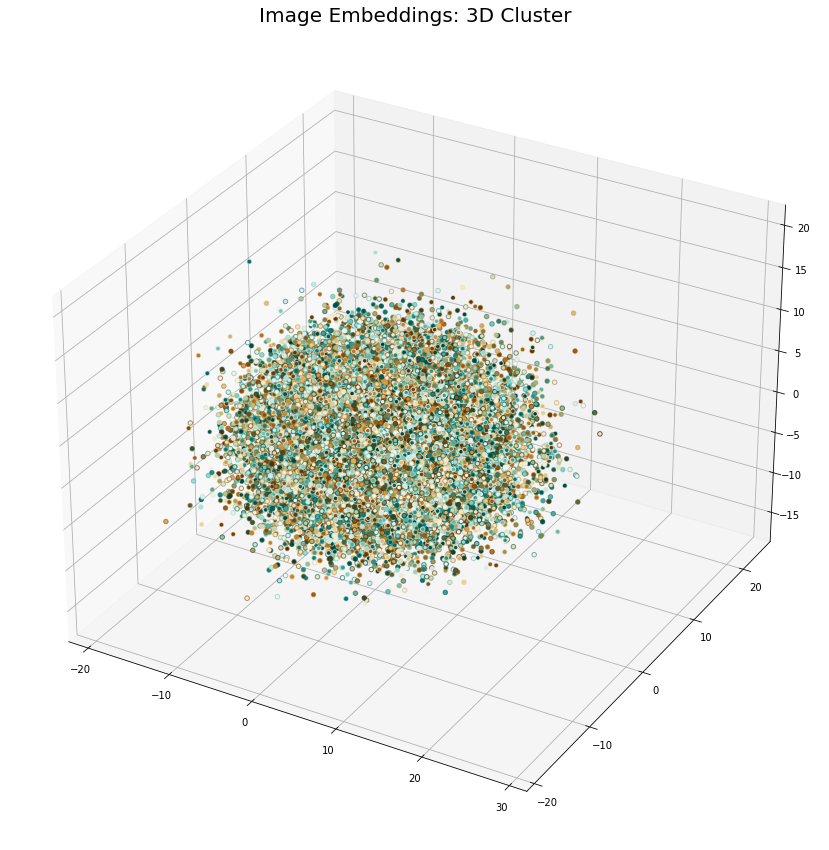

In [20]:
# Plot
fig = plt.figure(figsize=(20, 15))
ax = plt.axes(projection='3d')

ax.scatter3D(finalDf['pc_1'], finalDf['pc_2'], finalDf['pc_3'], c=finalDf['label_group'], cmap='BrBG')
ax.set_title('Image Embeddings: 3D Cluster', size=20);

In [21]:
del img_embeddings_df, X, pca, principalDf, finalDf, all_image_embeddings
_ = gc.collect()

In [22]:
# Extract the Tf-Idf Matrix 
tf_idf = TfidfVectorizer(stop_words='english', binary=True, max_features=25000)
text_embeddings = tf_idf.fit_transform(data_gpu["title"]).toarray()

print("Text Embeddings Matrix format: {:,}/{:,}".format(text_embeddings.shape[0], text_embeddings.shape[1]))

Text Embeddings Matrix format: 34,250/24,939


In [25]:
# Save image_embeddings to W&B
run = wandb.init(project='shopee-kaggle', name='text_embeddings')
artifact = wandb.Artifact(name='text_embeddings', 
                          type='dataset')

artifact.add_file("../input/shopee-preprocessed-data/text_embeddings.npy")

wandb.log_artifact(artifact)
wandb.log({"Length of Text embeddings" : text_embeddings.shape[1],
           "Width of Text embeddings" : text_embeddings.shape[0]})
wandb.finish()

In [26]:
def find_matches_cupy(X, posting_ids, threshold):
    X = cp.array(X)
    N = X.shape[1]
    matches = []

    for i in tqdm(range(N)):
        v = X[:, i].reshape(-1, 1)
        thresholded_bool = cp.linalg.norm(v - X, axis=0) < threshold
        thresholded_ix = cp.argwhere(thresholded_bool).squeeze(-1)
        thresholded_ix = thresholded_ix.get()
        match = " ".join(posting_ids[thresholded_ix])
        matches.append(match)

    return matches

In [27]:
# Creating the splits, to prevent memory errors
predictions = []
CHUNK = 1024 * 4  ### 4096

SPLITS = len(text_embeddings) // CHUNK
if len(text_embeddings) % CHUNK != 0: SPLITS += 1
print("Total Splits:", SPLITS)


# Making the prediction
print("Finding Similar Titles ...")

for no in range(SPLITS):
    
    a = no * CHUNK
    b = (no+1) * CHUNK
    b = min(b, len(text_embeddings))
    print("CHUNK:", a, "-", b)
    
    # Cosine similarity distance
    cts = cupy.matmul(text_embeddings, text_embeddings[a:b].T).T
    
    for k in range(b-a):
        index = cupy.where(cts[k,] > 0.7)[0]
        index = cupy.asnumpy(index)
        pred = data.iloc[index]["posting_id"].values
        
        predictions.append(pred)

        
# Clean environment
del tf_idf, text_embeddings
_ = gc.collect()

Total Splits: 9
Finding Similar Titles ...
CHUNK: 0 - 4096
CHUNK: 4096 - 8192
CHUNK: 8192 - 12288
CHUNK: 12288 - 16384
CHUNK: 16384 - 20480
CHUNK: 20480 - 24576
CHUNK: 24576 - 28672
CHUNK: 28672 - 32768
CHUNK: 32768 - 34250


In [28]:
# Add predictions to dataframe
data['title_pred'] = predictions
data.head(5)

,posting_id,image,image_phash,title,label_group,filepath,target,img_pred,title_pred
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,../input/shopee-product-matching/train_images/...,"[train_129225211, train_2278313361]",[train_129225211],"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,../input/shopee-product-matching/train_images/...,"[train_3386243561, train_3423213080]",[train_3386243561],[train_3386243561]
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,../input/shopee-product-matching/train_images/...,"[train_2288590299, train_3803689425]",[train_2288590299],[train_2288590299]
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,../input/shopee-product-matching/train_images/...,"[train_2406599165, train_3342059966]",[train_2406599165],"[train_2406599165, train_3576714541, train_150..."
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,../input/shopee-product-matching/train_images/...,"[train_3369186413, train_921438619]",[train_3369186413],[train_3369186413]


In [29]:
from cuml.experimental.preprocessing import StandardScaler as StandardScaler_gpu
from cuml.decomposition import PCA as PCA_gpu

In [30]:
#We will add all images that have the same phash are identical
duplicate_dict = data.groupby('image_phash').posting_id.agg('unique').to_dict()
data['duplic_pred'] = data["image_phash"].map(duplicate_dict)

In [31]:
def combine_predictions(row, cv=True):
    '''Combine all predictions together.'''
    
    # Combine all predictions
    all_preds = np.concatenate([row["img_pred"],row["title_pred"], row["duplic_pred"]])
    all_preds = np.unique(all_preds)
    
    # Return combined unique preds
    if cv == True:
        return all_preds
    else:
        return ' '.join(all_preds)

In [32]:
# Excute CV Score
if COMPUTE_CV == True:
    
    data["all_preds"] = data.apply(lambda x: combine_predictions(x, cv=True), axis=1)
    data["f1"] = data.apply(F1_score(target_column="target", pred_column="all_preds"), axis=1)
    print("CV Score: {:.3}".format(data["f1"].mean()))
    

data["matches"] = data.apply(lambda x: combine_predictions(x, cv=False), axis=1)

CV Score: 0.673
